In [183]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import mlflow
import mlflow.sklearn
import sklearn.metrics
from mlflow.models.signature import infer_signature
from sklearn.model_selection import GridSearchCV
import re
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc as auc_score_func
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import spacy
import gensim
nlp = spacy.load('en_core_web_lg')

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [184]:
def load_data():
    column_names = ["target", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", names=column_names, encoding='ISO-8859-1')
    display(df)
    return df

df = load_data()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [185]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

target    0.0
ids       0.0
date      0.0
flag      0.0
user      0.0
text      0.0
dtype: float64
Nombres de tweets dupliqués :  18534
col = target -> duplicated = 1599998
col = ids -> duplicated = 1685
col = date -> duplicated = 825637
col = flag -> duplicated = 1599999
col = user -> duplicated = 940225
col = text -> duplicated = 18534


0          False
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Name: text, Length: 1600000, dtype: bool


,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


,date,flag,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


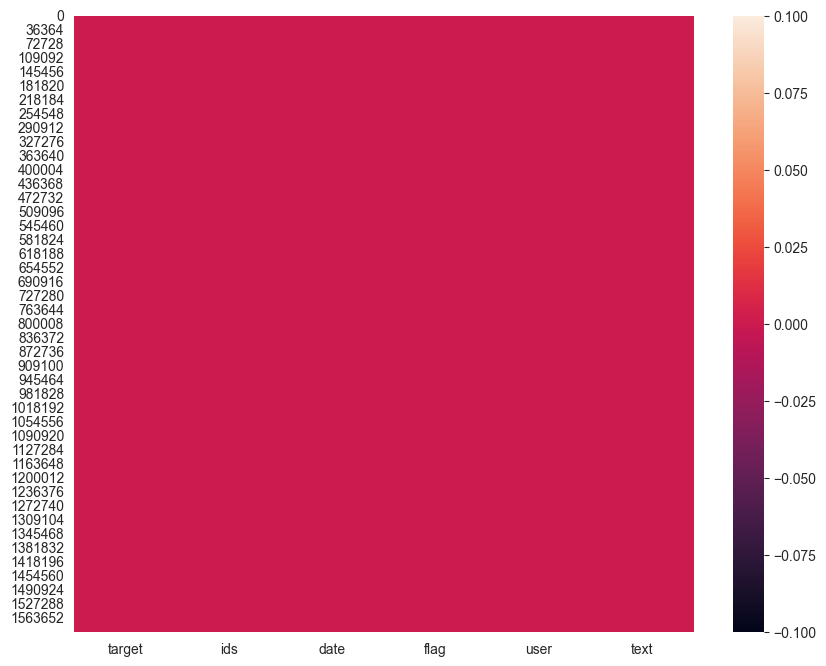

In [186]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print("Nombres de tweets dupliqués : ", data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

analyse_data(df)

Text(0.5, 1.0, 'Distribution du nombre de caractères des tweets')

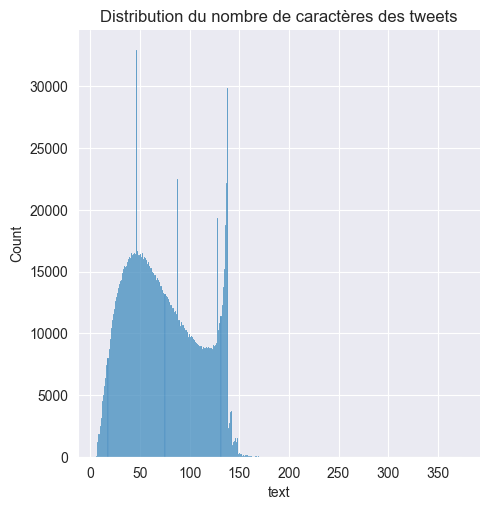

In [187]:
tmp = df.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des tweets")

In [188]:
def drop_columns(df):
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    df = df.drop_duplicates(subset="text")
    return df

df = drop_columns(df)
df = drop_text_duplicate(df)
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [189]:
def create_sample(df):
    negative_tweets = df[df.iloc[:, 0] == 0]
    negative_tweets = negative_tweets.sample(n = 10000, random_state=0)
    positive_tweets = df[df.iloc[:, 0] == 4]
    positive_tweets['target'] = positive_tweets['target'].replace({4:1})
    positive_tweets = positive_tweets.sample(n = 10000, random_state=0)
    df_sample = pd.concat([negative_tweets, positive_tweets], ignore_index=True)
    return df_sample
df_sample = create_sample(df)

In [190]:
df_sample.target.value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [191]:
def display_tokens_info(tokens):
    """display info about corpus"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])
eng_words = nltk.corpus.words.words()
display_tokens_info(eng_words)

nb tokens 236736, nb tokens uniques 235892
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [192]:
ps = nltk.PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

nb tokens 236736, nb tokens uniques 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


In [193]:
lm = nltk.WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
display_tokens_info(eng_words_lem)

nb tokens 236736, nb tokens uniques 235068
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [194]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [195]:
"""
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
"""

"\nnltk.download('omw-1.4')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('words')\n"

In [196]:
def process_text(doc,
                   rejoin=False,
                   lemm_or_stemm="stem",
                   min_len_word=2,
                   force_is_alpha=True):

    doc = doc.lower().strip()
    doc_spacy = nlp(doc)

    if lemm_or_stemm == "lem":
        trans_text = [token.lemma_ for token in doc_spacy]
    else:
        trans = nltk.PorterStemmer()
        trans_text = [trans.stem(i.text) for i in doc_spacy]

    #classic stopwords
    cleaned_tokens_list = [w for w in trans_text if w not in stop_words]

    #no more len words
    more_than_n = [w for w in cleaned_tokens_list if len(w) >= min_len_word]

      #only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_n if w.isalpha()]
    else:
        alpha_tokens = more_than_n

    #manage return type
    if rejoin:
        return " ".join(alpha_tokens)

    return alpha_tokens


def final_clean_stem(doc):
    new_doc = process_text(doc,
                             rejoin=True,
                             lemm_or_stemm="stem")
    return new_doc

def final_clean_lem(doc):
    new_doc = process_text(doc,
                             rejoin=True,
                             lemm_or_stemm="lem")
    return new_doc


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, function):
        self.function = function

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.function)

In [197]:
from tqdm import tqdm
tqdm.pandas()


df_sample['clean_text_stem'] = df_sample.text.progress_apply(final_clean_stem)
df_sample['clean_text_lem'] = df_sample.text.progress_apply(final_clean_lem)

100%|██████████| 20000/20000 [01:23<00:00, 238.29it/s]


In [198]:
df_sample

,target,text,clean_text_stem,clean_text_lem
0,0,homework Three projects is a lot of work!,homework three project lot work,homework three project lot work
1,0,thought i just saw sara walking into the cante...,thought saw sara walk canteen got excit think ...,think see sara walk canteen get excited thinki...
2,0,ow my heeaad,ow heeaad,ow heeaad
3,0,@meimeinono you're not missing much tonight. s...,miss much tonight show go,miss much tonight show go
4,0,@gab_iii I'm totally jealous of your hat and y...,total jealou hat shirt,totally jealous hat shirt
...,...,...,...,...
19995,1,Coming home from camping with K M and A my ar...,come home camp arm tire,come home camping arm tired
19996,1,@cheridennis Had to double check! Glad I don't...,doubl check glad send twolic see soon,double check glad send twolice see soon
19997,1,@nglalala oh my goodness! i just checked my @ ...,oh good check repli saw yay twitter excit ye w...,oh goodness check reply see yay twitter exciti...
19998,1,"Highly recomend UP! bring tissues, its pretty...",highli recomend bring tissu pretti sweet,highly recomend bring tissue pretty sweet


In [199]:
def train_valid_test_split(df, text, target, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=0):
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("Les proportions ne s'additionnent pas à 1.0")

    # divisez vos données en un ensemble d'apprentissage et un ensemble temporaire
    X_train, X_temp, y_train, y_temp = train_test_split(df[text],
                                                        df[target],
                                                        stratify=df[target],
                                                        test_size=1-train_size,
                                                        random_state=random_state)

    # calculer la taille relative des ensembles de validation et de test
    relative_test_size = test_size / (valid_size + test_size)

    # divisez l'ensemble temporaire en ensembles de validation et de test
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,
                                                        stratify=y_temp,
                                                        test_size=relative_test_size,
                                                        random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [200]:
def calcul_metrics(y_valid, y_valid_pred ,title, recover = False):
    #Ajouter le score ACCURACY
    print(title)
    print(classification_report(y_valid, y_valid_pred))
    precision = precision_score(y_valid, y_valid_pred)
    print("Precision Score", precision)
    recall = recall_score(y_valid, y_valid_pred)
    print("Recall Score :", recall)
    f1 = f1_score(y_valid, y_valid_pred)
    print("F1 Score", f1)
    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred)
    score_auc = auc_score_func(fpr, tpr)
    print("AUC :" , score_auc, "\n")
    if recover:
        return precision, recall, f1, score_auc

## Regression Logistique

### BoW

In [201]:
experiment_name = "Regression Logistique"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="TFIDF run"):
    params = {"penalty": "l2", "C": 1.0, "random_state": 0}
    pipeline = Pipeline([
        ('vect', TfidfVectorizer()),
        ('scale', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(**params))
    ])
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample, text= "clean_text_stem" ,target= 'target')
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    precision, recall, f1, score_auc = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Stemming et TF-IDF", recover=True)
    mlflow.log_param("preprocessing", "Stemming et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="tf-idf",
    )

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample, text= "clean_text_lem" ,target= 'target')
pipeline.fit(X_train, y_train)
y_valid_pred = pipeline.predict(X_valid)
calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Lemmatisation et TF-IDF :")

2023/06/26 03:46:31 INFO mlflow.tracking.fluent: Experiment with name 'Regression Logistique' does not exist. Creating a new experiment.


Performances sur le validation set avec Stemming et TF-IDF
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1000
           1       0.64      0.63      0.63      1000

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000

Precision Score 0.6359077231695085
Recall Score : 0.634
F1 Score 0.6349524286429643
AUC : 0.6355000000000001 



Registered model 'tf-idf' already exists. Creating a new version of this model...
2023/06/26 03:46:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf, version 2
Created version '2' of model 'tf-idf'.


Performances sur le validation set avec Lemmatisation et TF-IDF :
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1000
           1       0.64      0.63      0.64      1000

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000

Precision Score 0.6391129032258065
Recall Score : 0.634
F1 Score 0.6365461847389559
AUC : 0.6379999999999999 



### Word embedding

In [202]:
def create_vectors(nlp, X_train, X_valid, X_test):
    X_train = [nlp(tweet).vector for tweet in X_train]
    X_valid = [nlp(tweet).vector for tweet in X_valid]
    X_test = [nlp(tweet).vector for tweet in X_test]
    X_train = np.array(X_train)
    X_valid = np.array(X_valid)
    X_test = np.array(X_test)
    return X_train, X_valid, X_test

In [203]:
mlflow.set_tracking_uri('file://' + os.path.abspath('mlruns'))
with mlflow.start_run(run_name="Word Embedding run"):
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample, text="clean_text_lem" ,target= 'target')
    X_train, X_valid, X_test = create_vectors(nlp, X_train, X_valid, X_test)
    params = {"penalty": "l2", "C": 1.0, "random_state": 0}

    pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(**params))
    ])
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)

    precision, recall, f1, score_auc = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Lemmatisation et Word2Vec", recover=True)
    mlflow.log_param("preprocessing", "Lemmatization and Word2Vec")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="word2vec",
    )

Performances sur le validation set avec Lemmatisation et Word2Vec
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1000
           1       0.72      0.72      0.72      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000

Precision Score 0.7165510406342914
Recall Score : 0.723
F1 Score 0.7197610751617721
AUC : 0.7184999999999999 



Registered model 'word2vec' already exists. Creating a new version of this model...
2023/06/26 03:47:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: word2vec, version 2
Created version '2' of model 'word2vec'.


In [206]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [204]:
parameters = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2'],
    "solver" : ['newton-cg', 'lbfgs', 'liblinear']
}
grid_search = GridSearchCV(pipeline, parameters, cv=10, scoring='accuracy')

with mlflow.start_run(run_name="GridSearchCV run"):
    grid_search.fit(X_train, y_train)

    mlflow.log_param("C", grid_search.best_params_['clf__C'])
    mlflow.log_param("penalty", grid_search.best_params_['clf__penalty'])
    mlflow.log_param("solver", grid_search.best_params_['solver'])

    y_valid_pred = grid_search.predict(X_valid)
    precision_valid_set, recall_valid_set, f1_valid_set, auc_score_valid_set = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Lemmatisation, Word2Vec et GridSearch", recover=True)
    y_test_pred = grid_search.predict(X_test)
    precision_test_set, recall_test_set, f1_test_set, auc_score_test_set = calcul_metrics(y_test, y_test_pred, "Performances sur le test set avec Lemmatisation, Word2Vec et GridSearch", recover=True)
    mlflow.log_metrics({
    "valid_precision_score": precision_valid_set,
    "valid_recall_score": recall_valid_set,
    "valid_f1_score": f1_valid_set,
    "valid_auc": auc_score_valid_set,
    })
    mlflow.log_metrics({
    "test_precision_score": precision_test_set,
    "test_recall_score": recall_test_set,
    "test_f1_score": f1_test_set,
    "test_auc": auc_score_test_set,
    })
    signature = infer_signature(X_test, y_test_pred)
    mlflow.sklearn.log_model(
        sk_model=grid_search.best_estimator_,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="GridSearchCV",
    )

ValueError: 'f1_score' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    '''
    Prend en entrée les prédictions et les probabilités de prédiction d'un modèle, ainsi que les vraies étiquettes
    (y_true) . Elle affiche ensuite une matrice d confusion

    Args:
    - y_true, y_pred

    Returns:
    - Graphiques : Matrice de confusion
    '''
    fig = plt.figure(figsize=(20,15))

    conf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"size": 15})
    plt.xlabel("Predictions", fontsize=16)
    plt.ylabel("Étiquettes réelles", fontsize=16)
    plt.title("Matrice de Confusion")
    plt.show()